# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [68]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [69]:
# ¿De qué recursos de procesamiento disponemos?
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [70]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(f"¿Estamos en Colab? {'Sí' if IN_COLAB is True else 'No'}")

¿Estamos en Colab? No


In [71]:
# Una semilla aleatoria para toda la ejecución
RANDOM_SEED = 202
np.random.seed(RANDOM_SEED)

In [72]:
# Si no estamos en colab, no es necesario que estemos venga a descargar el dataset...
# Ya lo tenemos descargado de antemano :)
if IN_COLAB is True:
    # Primero, bajamos los datos de entrenamiento
    keras.utils.get_file(fname="simpsons_train.tar.gz", 
                         origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")
    
    # Descomprimimos el archivo
    !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets
    
    
    # Hacemos lo mismo con los datos de test
    keras.utils.get_file(fname="simpsons_test.tar.gz", 
                         origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
    !tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [73]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [74]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [75]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [76]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons" if IN_COLAB is True else "./data/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset" if IN_COLAB is True else "./data/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [77]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

abraham_grampa_simpson


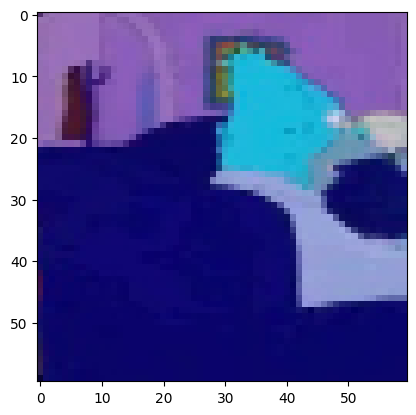

In [78]:
plt.imshow(X_test[2]) # recordad que siempre es preferible trabajar en blanco y negro
print(MAP_CHARACTERS[y_test[2]])

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [79]:
# Verificamos el soporte para GPU
if tf.test.gpu_device_name():
    print("Soporte para GPU habilitado.")
    print('Dispositivo GPU por defecto: {}'.format(tf.test.gpu_device_name()))
else:
    print("Soporte para GPU deshabilitado.")

Soporte para GPU habilitado.
Dispositivo GPU por defecto: /device:GPU:0


2024-05-30 20:43:19.772686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 20:43:19.772876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 20:43:19.772914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 20:43:19.773535: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 20:43:19.773546: I tensorflow/core/common_runtime/gpu/gpu

In [80]:
# Verificamos el soporte para TPU (aunque no hemos adaptado los modelos para trabajar con TPUs)
HAS_TPU_SUPPORT=0
if 'COLAB_TPU_ADDR' not in os.environ:
  print('TPU support disabled.')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU support enabled.')
  HAS_TPU_SUPPORT=1
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()

  print('TPU devices:')
  pprint.pprint(devices)

TPU support disabled.


In [82]:
# Definimos un par de funciones para dibujar gráficos de la precisión y de la pérdida
def plot_acc(history, title="Model Accuracy"):
    """
        Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_loss(history, title="Model Loss"):
    """
        Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento
    """
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

## 1. Análisis de datos y preparación

El conjunto de datos, originalmente, viene preparado en:
- Datos de entrenamiento.
- Datos de test.

Sin embargo, nos faltaría un conjunto de datos útil: el de validación.

A continuación dividimos el dataset de entrenamiento y nos quedamos con el 80% para entrenamiento y el 20% restante para validación

In [83]:
# De los datos de entrenamiento sacamos un 20% de datos para validación.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Tenemos el siguiente conjunto de datos:
- Entrenamiento: X_train, y_train
- Test: X_test, y_test
- Validación: X_val, y_val

In [85]:
# Variables con número de elementos
X_train_num_elem = X_train.shape[0]
X_test_num_elem = X_test.shape[0]
X_val_num_elem = X_val.shape[0]
print("Training shape:", X_train_num_elem,
      "\nTest shape:", X_test_num_elem,
      "\nTest shape:", X_val_num_elem)

Training shape: 15193 
Test shape: 890 
Test shape: 3799


In [86]:
# Dimensiones
img_rows = IMG_SIZE
img_cols = IMG_SIZE
img_channels = X.shape[3]
print("Cada imagen tiene dimensión", img_rows,
      "x", img_cols,
      "\nY tiene", img_channels, "capas (una para cada componente del color).")

Cada imagen tiene dimensión 60 x 60 
Y tiene 3 capas (una para cada componente del color).


In [87]:
# Número de categorías
num_categ = len(MAP_CHARACTERS)
print("Hay", num_categ, "categorías, una para cada personaje.")

Hay 18 categorías, una para cada personaje.


In [88]:
# Comprobamos que efectivamente los resultados son los esperados
print(f" > Número de imágenes de anterior training: {X.shape[0]}")
print(f" > Número de imágenes de training (80% de anterior train): {X_train_num_elem}")
print(f" > Número de imágenes de validación (20% de anterior train): {X_val_num_elem}")
print(f" > Número de imágenes de test: {X_test_num_elem}")
print(f" > Número de resultados de anterior training: {y.shape[0]}")
print(f" > Número de resultados de training (80% de anterior train): {y_train.shape[0]}")
print(f" > Número de resultadoss de validación (20% de anterior train): {y_val.shape[0]}")
print(f" > Número de resultados de test: {y_test.shape[0]}")
print(f" > Dimensiones de training: {X_train.shape}")
print(f" > Dimensiones de validation: {X_val.shape}")
print(f" > Dimensiones de tests: {X_test.shape}")
print(f" > Canales de color para las imagenes: {img_channels}")
print(f" > Resolución imágenes de anterior training: {X.shape[1]}x{X.shape[2]}")
print(f" > Resolución imágenes de training (80% de anterior train): {X_train.shape[1]}x{X_train.shape[2]}")
print(f" > Resolución imágenes de validación (20% de anterior train): {X_val.shape[1]}x{X_val.shape[2]}")
print(f" > Resolución imágenes de test: {X_test.shape[1]}x{X_test.shape[2]}")

 > Número de imágenes de anterior training: 18992
 > Número de imágenes de training (80% de anterior train): 15193
 > Número de imágenes de validación (20% de anterior train): 3799
 > Número de imágenes de test: 890
 > Número de resultados de anterior training: 18992
 > Número de resultados de training (80% de anterior train): 15193
 > Número de resultadoss de validación (20% de anterior train): 3799
 > Número de resultados de test: 890
 > Dimensiones de training: (15193, 60, 60, 3)
 > Dimensiones de validation: (3799, 60, 60, 3)
 > Dimensiones de tests: (890, 60, 60, 3)
 > Canales de color para las imagenes: 3
 > Resolución imágenes de anterior training: 60x60
 > Resolución imágenes de training (80% de anterior train): 60x60
 > Resolución imágenes de validación (20% de anterior train): 60x60
 > Resolución imágenes de test: 60x60


In [89]:
# Comprobamos el formato de cada muestra...
if keras.backend.image_data_format() == "channels_first":
  # ...si los canales van primero (channels, rows, cols):
  X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
  X_val = X_val.reshape(X_val.shape[0], img_channels, img_rows, img_cols)
  X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
  input_shape = (img_channels, img_rows, img_cols)
else:
  # ...sino, si los canales van último (rows, cols, channels):
  X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
  X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, img_channels)
  X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
  input_shape = (img_rows, img_cols, img_channels)

## 2. Normalización de datos

Como hicimos en la primera práctica, tenemos que normalizar los datos

In [90]:
# Normalizamos y convertimos a float32, de tal manera que seamos capaces de tener valores entre 0 y 1
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

# Con esto obtenemos valores entre el rango 0...1
X_train /= 255
X_val /= 255
X_test /= 255

# Con esto conseguimos trabajar con categorías en las y (las etiquetas)
y_train = keras.utils.to_categorical(y_train, num_categ)
y_val = keras.utils.to_categorical(y_val, num_categ)
y_test = keras.utils.to_categorical(y_test, num_categ)

Asi, ya tendríamos preparados todos los conjuntos de datos para poner a definir los modelos con los que vamos a trabajar.

## 3. Entrenamiento

Pasamos a definir los modelos.


In [91]:
# Definimos aquí más imports para no tener que ir más arriba en el notebook
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Softmax
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.src.legacy.preprocessing.image import ImageDataGenerator

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


#### 3.1. M1

En este primer modelo, introducimos:

- 2 capas convolucionales `Conv2D`:
    - La primera con 32 filtros de convolución, tamaño de kernel de 3x3 y función de activación relu. Con input_shape indicamos la forma de la entrada de la red.
    - La segunda con 64 filtros de convolución, el resto igual que la anterior capa.  
- 1 capa de pooling `MaxPooling2D` que reduce la dimensionalidad de las características. Con `max`, se queda con el valor máximo en una ventana de 2x2-
- 1 capa `Dropout` para reducir el sobreajuste con probabilidad de desactivación del 25%. Se evita el sobreajuste desactivando una parte de las neuronas durante el entrenamiento.
- 1 capa `Flatten` que transforma la salida de las capas convolucionales en un vector unidimensional.
- Capas convolucionales posteriores:
    - Capa densa de 128 neuronas y función de activación relu.
    - 1 capa `Dropout` con una probabilidad de desactivación de neuronas del 50%.
    - 1 capa densa softmax que nos devuelve la probabilidad de cada categoría multiclase.  

Usamos el optimizador Adagrad con un learning-rate del 0.03.

Entrenamos 40 epochs con un batch size de 128. 

In [92]:
m1 = Sequential()
m1.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m1_conv2d_1"))
m1.add(Conv2D(64, kernel_size=(3, 3), activation="relu", name="m1_conv2d_2"))
m1.add(MaxPooling2D(pool_size=(2, 2), name="m1_maxpool2d_1"))
m1.add(Dropout(0.25, name="m1_dropout_1"))
m1.add(Flatten(name="m1_flatten"))
m1.add(Dense(128, activation="relu", name="m1_dense_1"))
m1.add(Dropout(0.5, name="m1_dropout_2"))
m1.add(Dense(num_categ, activation="softmax", name="m1_softmax"))

m1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m1_conv2d_1 (Conv2D)            │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_conv2d_2 (Conv2D)            │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_maxpool2d_1 (MaxPooling2D)   │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_dropout_1 (Dropout)          │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_flatten (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_dense_1 (Dense)              │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_dropout_2 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_softmax (Dense)              │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,444,370 (24.58 MB)

 Trainable params: 6,444,370 (24.58 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Optimizador: ADAGRAD

"""
  Hyperparams:
   - Learning rate (learning_rate): 0.03
"""
m1_opt = Adagrad(learning_rate=0.03)

m1.compile(
    loss="categorical_crossentropy",
    optimizer=m1_opt,
    metrics=["accuracy"]
)

In [94]:
# Entrenamiento
m1_batch_size = 128
m1_epochs = 40

m1_hist = m1.fit(X_train, y_train,
  batch_size=m1_batch_size,
  epochs=m1_epochs,
  verbose=True,
  validation_data=(X_val, y_val)
)

Epoch 1/40
  7/119 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0918 - loss: 2.9397

W0000 00:00:1717094604.430730   18454 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1445 - loss: 2.7352

W0000 00:00:1717094609.357954   18456 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717094610.049353   18458 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.1449 - loss: 2.7339 - val_accuracy: 0.3543 - val_loss: 2.2085
Epoch 2/40
  5/119 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2739 - loss: 2.3594

W0000 00:00:1717094610.435750   18456 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3465 - loss: 2.1514 - val_accuracy: 0.4988 - val_loss: 1.7178
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4736 - loss: 1.7699 - val_accuracy: 0.5588 - val_loss: 1.5022
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5376 - loss: 1.5439 - val_accuracy: 0.6152 - val_loss: 1.3574
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5832 - loss: 1.3935 - val_accuracy: 0.6523 - val_loss: 1.2133
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6222 - loss: 1.2459 - val_accuracy: 0.6586 - val_loss: 1.1747
Epoch 7/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6560 - loss: 1.1282 - val_accuracy: 0.6683 - val_loss: 1.1164
Epoch 8/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6914 - loss: 1.0201 - val_accuracy: 0.6910 - val_loss: 1.0662
Epoch 9/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7315 - loss: 0.8812 - val_accuracy: 0.702

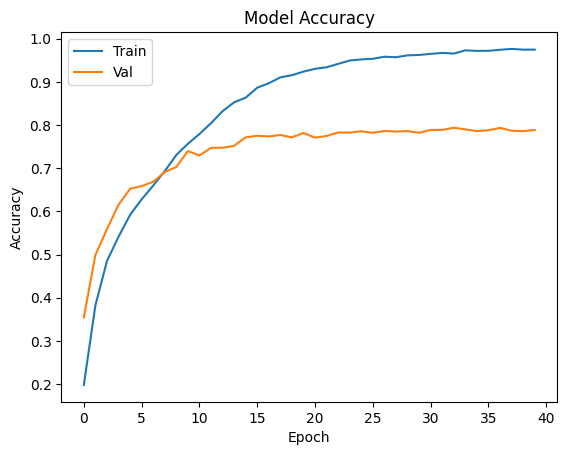

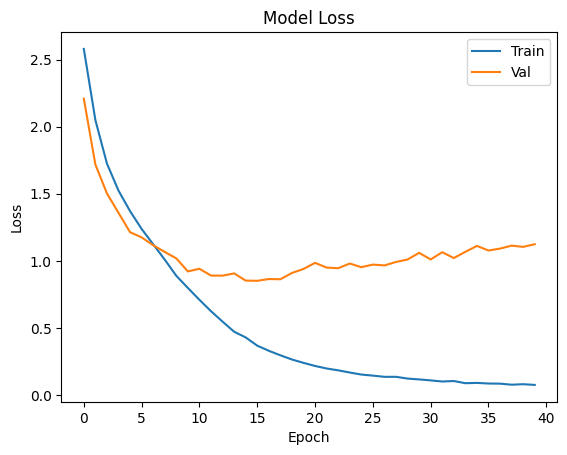

In [95]:
# Análisis loss/accuracy o pérdida/precisión

plot_acc(m1_hist)
plot_loss(m1_hist)

In [96]:
# Test
m1_score = m1.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m1_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m1_score[1]))
print("Accuracy (Datos de test) en % : " + str(m1_score[1]*100))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9388 - loss: 0.3982
Evaluación del modelo (Datos de test) - Loss : 0.27140793204307556
Evaluación del modelo (Datos de test) - Accuracy : 0.9528089761734009
Accuracy (Datos de test) en % : 95.28089761734009


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<Figure size 1000x800 with 0 Axes>

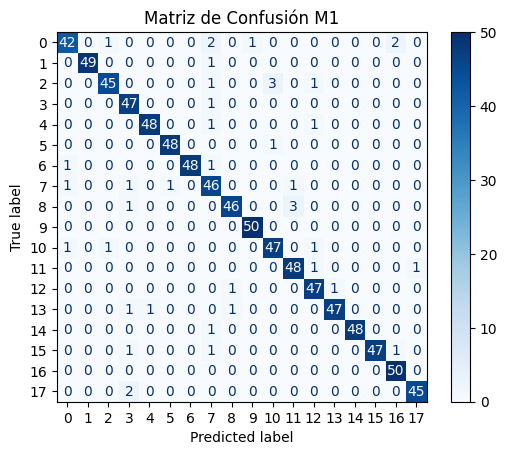

In [97]:
# Predecir las clases en los datos de prueba
y_pred_m1 = np.argmax(m1.predict(X_test), axis=1)
y_true_m1 = np.argmax(y_test, axis=1)

# Generar la matriz de confusión
cm_m1 = confusion_matrix(y_true_m1, y_pred_m1)
cm_display_m1 = ConfusionMatrixDisplay(confusion_matrix=cm_m1, display_labels=[i for i in range(len(np.unique(y_true_m1)))])

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm_display_m1.plot(cmap=plt.cm.Blues, values_format='g')
plt.title('Matriz de Confusión M1')
plt.show()

In [98]:
report_m1 = classification_report(y_true_m1, y_pred_m1, target_names=[f'Clase {i} {MAP_CHARACTERS[i]}' for i in range(len(np.unique(y_true_m1)))])
print("\nInforme de clasificación M1:\n", report_m1)


Informe de clasificación M1:
                                   precision    recall  f1-score   support

  Clase 0 abraham_grampa_simpson       0.93      0.88      0.90        48
  Clase 1 apu_nahasapeemapetilon       1.00      0.98      0.99        50
            Clase 2 bart_simpson       0.96      0.90      0.93        50
Clase 3 charles_montgomery_burns       0.89      0.98      0.93        48
            Clase 4 chief_wiggum       0.98      0.96      0.97        50
          Clase 5 comic_book_guy       0.98      0.98      0.98        49
          Clase 6 edna_krabappel       1.00      0.96      0.98        50
           Clase 7 homer_simpson       0.84      0.92      0.88        50
           Clase 8 kent_brockman       0.96      0.92      0.94        50
        Clase 9 krusty_the_clown       0.98      1.00      0.99        50
           Clase 10 lisa_simpson       0.92      0.94      0.93        50
          Clase 11 marge_simpson       0.92      0.96      0.94        50
    Cl

CONCLUSIONES

Como vemos en los resultados de la ejecución, superamos ampliamente el 85% de accuracy en test, obteniendo un 95%. Sin embargo, como vemos, los resultados de validación son mucho peores que los de test, lo que nos hace intuir que puede existir sobre-ajuste. Por lo tanto, seguimos en la búsqueda de un modelo mejor.

#### **3.2. M2** Modelo propuesto por un proceso de autoselección de parámetros


Se realiza una selección automática de parámetros para tratar de mejorar el modelo anterior.
Este fragmento de código resulta muy costoso computacionalmente.

In [ ]:
def create_model(learning_rate=0.001, dropout_rate=0.5):
    m_prop = Sequential()
    m_prop.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
    m_prop.add(MaxPooling2D(pool_size=(2, 2)))
    m_prop.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    m_prop.add(MaxPooling2D(pool_size=(2, 2)))
    m_prop.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
    m_prop.add(MaxPooling2D(pool_size=(2, 2)))
    m_prop.add(Flatten())
    m_prop.add(Dense(128, activation="relu"))
    m_prop.add(Dropout(dropout_rate))
    m_prop.add(Dense(num_categ, activation="softmax"))

    optimizer = Adam(learning_rate=learning_rate)
    m_prop.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return m_prop

m_prop = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=1,dropout_rate=0.3, learning_rate=0.01)

param_grid_prop = {
    'learning_rate': [0.001, 0.01, 0.02, 0.03],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [32, 64, 128],
    'epochs': [20, 30]
}

grid_prop = GridSearchCV(estimator=m_prop, param_grid=param_grid_prop, n_jobs=-1, cv=3)
grid_result_prop = grid_prop.fit(X_train, y_train)

print("Mejores parámetros: %s usando %s" % (grid_result_prop.best_score_, grid_result_prop.best_params_))

**M2:** Se prueban los mejores parámetros dados en el auto entrenamiento:

| Nombre modelo | Cant. capas | Func. act. | Optimizador | Caracts. extra |
| ------------- | ----------- | ---------- | ----------- | -------------- |
|       M2      |             |            |             |                |

#### **3.3. M3** Se cambia la arquitectura y el número de capas del modelo anterior en un intento de mejora:

| Nombre modelo | Cant. capas | Func. act. | Optimizador | Caracts. extra |
| ------------- | ----------- | ---------- | ----------- | -------------- |
|       M3      |             |            |             |                   |

In [99]:
m3 = Sequential()
m3.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m3_conv2d_1"))
m3.add(AveragePooling2D(pool_size=(2, 2), name="m3_maxpool2d_1"))
m3.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu",  name="m3_conv2d_2"))
m3.add(AveragePooling2D(pool_size=(2, 2), name="m3_maxpool2d_2"))
m3.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", name="m3_conv2d_3"))
m3.add(AveragePooling2D(pool_size=(2, 2), name="m3_maxpool2d_3"))
#m3.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m3_conv2d_4"))
#m3.add(AveragePooling2D(pool_size=(2, 2), name="m3_maxpool2d_4"))
m3.add(Flatten(name="m3_flatten"))
m3.add(Dense(units=128, activation="relu", name="m3_dense_1"))
m3.add(Dropout(0.3, name="m3_dropout_1"))
m3.add(Dense(units=64, activation="relu", name="m3_dense_2"))
#m3.add(Dropout(0.3, name="m3_dropout_2"))
m3.add(Dense(num_categ, activation="softmax", name="m3_softmax"))

m3.summary()

/home/joninazio/.virtualenvs/mia-sca-act2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m3_conv2d_1 (Conv2D)            │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_maxpool2d_1                  │ (None, 29, 29, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_conv2d_2 (Conv2D)            │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_maxpool2d_2                  │ (None, 13, 13, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_conv2d_3 (Conv2D)            │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_maxpool2d_3                  │ (None, 5, 5, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_flatten (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_dense_1 (Dense)              │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_dropout_1 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_dense_2 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_softmax (Dense)              │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,402 (1.95 MB)

 Trainable params: 512,402 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
# Optimizador:ADAM
m3_opt = Adam(learning_rate=0.001)

m3.compile(
    loss="categorical_crossentropy",
    optimizer=m3_opt,
    metrics=["accuracy"]
)

In [101]:
# Añadimos Early Stopping de val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [102]:
# Entrenamiento
m3_batch_size = 32
m3_epochs = 50

m3_hist = m3.fit(X_train, y_train, batch_size=m3_batch_size,
                epochs=m3_epochs,
                verbose=True,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping]
)

Epoch 1/50
 23/475 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0647 - loss: 2.8779

W0000 00:00:1717094750.172855   18454 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1874 - loss: 2.5917

W0000 00:00:1717094755.459388   18457 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


475/475 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.1875 - loss: 2.5912 - val_accuracy: 0.4435 - val_loss: 1.8564
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4452 - loss: 1.8251 - val_accuracy: 0.5880 - val_loss: 1.3726
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5648 - loss: 1.4205 - val_accuracy: 0.6568 - val_loss: 1.1591
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6386 - loss: 1.1883 - val_accuracy: 0.7012 - val_loss: 1.0023
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6969 - loss: 0.9765 - val_accuracy: 0.7418 - val_loss: 0.8719
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7473 - loss: 0.8130 - val_accuracy: 0.7634 - val_loss: 0.8015
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7794 - loss: 0.7089 - val_accuracy: 0.7770 - val_loss: 0.7734
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8111 - loss: 0.6008 - val_accuracy: 0.7923 - val

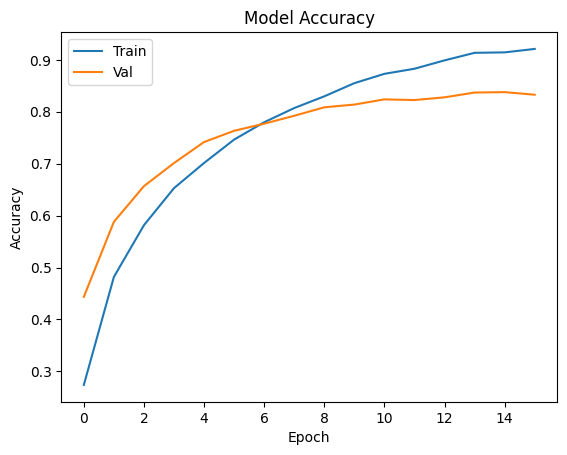

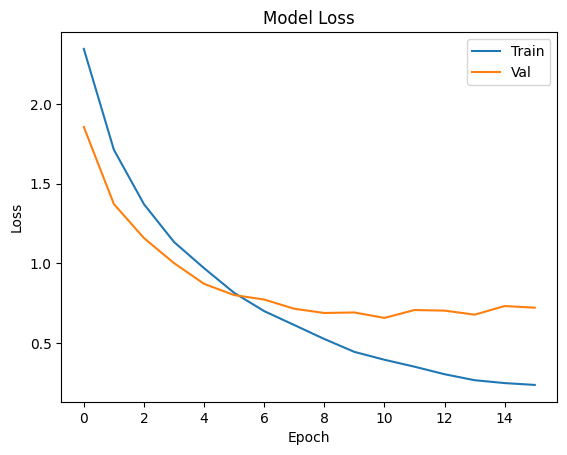

In [103]:
# Análisis loss/accuracy o pérdida/precisión

plot_acc(m3_hist)
plot_loss(m3_hist)

In [104]:
# Test
m3_score = m3.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m3_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m3_score[1]))
print("Accuracy (Datos de test) en % : " + str(m3_score[1]*100))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9161 - loss: 0.3432
Evaluación del modelo (Datos de test) - Loss : 0.27167007327079773
Evaluación del modelo (Datos de test) - Accuracy : 0.9404494166374207
Accuracy (Datos de test) en % : 94.04494166374207


 1/28 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step

W0000 00:00:1717094802.440050   18457 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<Figure size 1000x800 with 0 Axes>

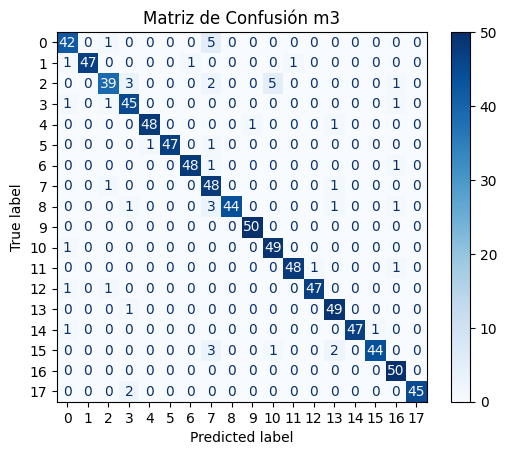

In [105]:
# Predecir las clases en los datos de prueba
y_pred_m3 = np.argmax(m3.predict(X_test), axis=1)
y_true_m3 = np.argmax(y_test, axis=1)

# Generar la matriz de confusión
cm_m3 = confusion_matrix(y_true_m3, y_pred_m3)
cm_display_m3 = ConfusionMatrixDisplay(confusion_matrix=cm_m3, display_labels=[i for i in range(len(np.unique(y_true_m3)))])

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm_display_m3.plot(cmap=plt.cm.Blues, values_format='g')
plt.title('Matriz de Confusión m3')
plt.show()

In [106]:
report_m3 = classification_report(y_true_m3, y_pred_m3, target_names=[f'Clase {i} {MAP_CHARACTERS[i]}' for i in range(len(np.unique(y_true_m3)))])
print("\nInforme de clasificación m3:\n", report_m3)


Informe de clasificación m3:
                                   precision    recall  f1-score   support

  Clase 0 abraham_grampa_simpson       0.89      0.88      0.88        48
  Clase 1 apu_nahasapeemapetilon       1.00      0.94      0.97        50
            Clase 2 bart_simpson       0.91      0.78      0.84        50
Clase 3 charles_montgomery_burns       0.87      0.94      0.90        48
            Clase 4 chief_wiggum       0.98      0.96      0.97        50
          Clase 5 comic_book_guy       1.00      0.96      0.98        49
          Clase 6 edna_krabappel       0.98      0.96      0.97        50
           Clase 7 homer_simpson       0.76      0.96      0.85        50
           Clase 8 kent_brockman       1.00      0.88      0.94        50
        Clase 9 krusty_the_clown       0.98      1.00      0.99        50
           Clase 10 lisa_simpson       0.89      0.98      0.93        50
          Clase 11 marge_simpson       0.98      0.96      0.97        50
    Cl

CONCLUSIONES

En este modelo hemos variado un poco la arquitectura. Hemos añadido una capa convolucional más, además de añadir un average pooling, y hemos relajado el learning_rate. Como consecuencia, hemos mejorado los resultados de validación, aunque seguimos teniendo una pérdida significativa.

Creemos que podríamos tener mejores resultados en sucesivos intentos. 

#### **3.4. M4** Se añade Data Augmentation:

| Nombre modelo | Cant. capas | Func. act. | Optimizador | Caracts. extra |
| ------------- | ----------- | ---------- | ----------- | -------------- |
|       M4      |             |            |             |                |

Con respecto al modelo anterior, añadimos una capa convolucional más, empleamos batch normalization y vamos a hacer uso de DataAugmentation. 

In [107]:
m4 = Sequential()
m4.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m4_conv2d_1"))
m4.add(AveragePooling2D(pool_size=(2, 2), name="m4_maxpool2d_1"))
m4.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="m4_conv2d_2"))
m4.add(AveragePooling2D(pool_size=(2, 2), name="m4_maxpool2d_2"))
m4.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", name="m4_conv2d_3"))
m4.add(AveragePooling2D(pool_size=(2, 2), name="m4_maxpool2d_3"))
m4.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="m4_conv2d_4"))
m4.add(AveragePooling2D(pool_size=(2, 2), name="m4_maxpool2d_4"))
m4.add(Flatten(name="m4_flatten"))
m4.add(Dense(units=128, activation="relu", name="m4_dense_1"))
m4.add(Dropout(0.5, name="m4_dropout_1"))
m4.add(BatchNormalization(name="m4_batch_norm_1"))
m4.add(Dense(units=64, activation="relu", name="m4_dense_2"))
m4.add(Dropout(0.5, name="m4_dropout_2"))
m4.add(BatchNormalization(name="m4_batch_norm_2"))
m4.add(Dense(num_categ, activation="softmax", name="m4_softmax"))

m4.summary()

/home/joninazio/.virtualenvs/mia-sca-act2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m4_conv2d_1 (Conv2D)            │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_maxpool2d_1                  │ (None, 29, 29, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_conv2d_2 (Conv2D)            │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_maxpool2d_2                  │ (None, 13, 13, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_conv2d_3 (Conv2D)            │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_maxpool2d_3                  │ (None, 5, 5, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_conv2d_4 (Conv2D)            │ (None, 3, 3, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_maxpool2d_4                  │ (None, 1, 1, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_flatten (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_dense_1 (Dense)              │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_dropout_1 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_batch_norm_1                 │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_dense_2 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_dropout_2 (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_batch_norm_2                 │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m4_softmax (Dense)              │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,554 (724.82 KB)

 Trainable params: 185,170 (723.32 KB)

 Non-trainable params: 384 (1.50 KB)

In [108]:
# Optimizador: ADAM
m4_opt = Adam(learning_rate=0.001)

m4.compile(
    loss="categorical_crossentropy",
    optimizer=m4_opt,
    metrics=["accuracy"]
)

In [109]:
# Data Augmentation
datagen_m4 = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_m4.fit(X_train)

In [110]:
# Añadimos callbacks: EarlyStopping y Model Checkpoint
m4_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        # min_delta = 0.001,
        # mode="max",
        patience = 10,
        verbose = 1,
        # restore_best_weights = True
    ),

    # ModelCheckpoint(
    #     filepath='./model_m3.keras',
    #     save_weights_only=False,
    #     monitor='val_accuracy',
    #     mode='max',
    #     save_best_only=True)
]

In [111]:
# Entrenamiento
m4_batch_size = 32
m4_epochs = 50

m4_hist = m4.fit(datagen_m4.flow(X_train, y_train, batch_size=m4_batch_size),
                epochs=m4_epochs,
                verbose=True,
                validation_data=(X_val, y_val),
                callbacks=m4_callbacks
)

Epoch 1/50


/home/joninazio/.virtualenvs/mia-sca-act2/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  9/475 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.0531 - loss: 3.5812

W0000 00:00:1717094809.378756   18458 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


468/475 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0693 - loss: 3.3168

W0000 00:00:1717094824.716399   18454 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


475/475 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.0694 - loss: 3.3140 - val_accuracy: 0.1108 - val_loss: 2.9323
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.1049 - loss: 2.8618 - val_accuracy: 0.1866 - val_loss: 2.6147
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.1445 - loss: 2.7103 - val_accuracy: 0.1985 - val_loss: 2.5522
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.1710 - loss: 2.6475 - val_accuracy: 0.2174 - val_loss: 2.4819
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.1771 - loss: 2.5933 - val_accuracy: 0.2208 - val_loss: 2.4546
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.2004 - loss: 2.5059 - val_accuracy: 0.2158 - val_loss: 2.3740
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.2392 - loss: 2.3752 - val_accuracy: 0.3393 - val_loss: 1.9974
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.2950 - loss: 2.1927 - val_accurac

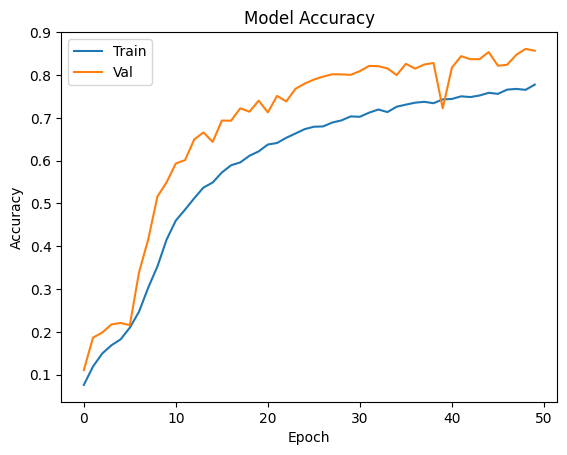

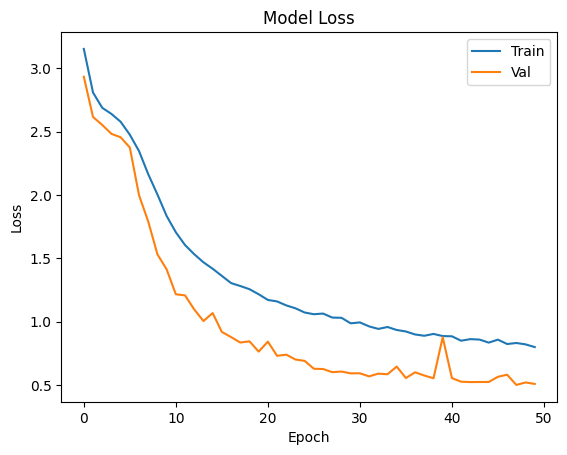

In [112]:
# Análisis loss/accuracy o pérdida/precisión

plot_acc(m4_hist)
plot_loss(m4_hist)

In [113]:
# Test
m4_score = m4.evaluate(X_test, y_test, verbose=True)

print(f"M4 - Test Loss: {m4_score[0]}")
print(f"M4 - Test Accuracy: {m4_score[1]}, {m4_score[1]*100}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8300 - loss: 0.5172
M4 - Test Loss: 0.4497886002063751
M4 - Test Accuracy: 0.8640449643135071, 86.40449643135071%


26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

W0000 00:00:1717095404.012312   18456 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


<Figure size 1000x800 with 0 Axes>

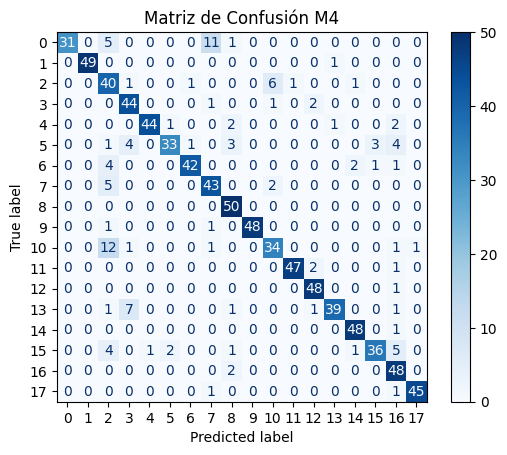

In [114]:
# Predecir las clases en los datos de prueba
y_pred_m4 = np.argmax(m4.predict(X_test), axis=1)
y_true_m4 = np.argmax(y_test, axis=1)

# Generar la matriz de confusión
cm_m4 = confusion_matrix(y_true_m4, y_pred_m4)
cm_display_m4 = ConfusionMatrixDisplay(confusion_matrix=cm_m4, display_labels=[i for i in range(len(np.unique(y_true_m4)))])

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm_display_m4.plot(cmap=plt.cm.Blues, values_format='g')
plt.title('Matriz de Confusión M4')
plt.show()

In [115]:
report_m4 = classification_report(y_true_m4, y_pred_m4, target_names=[f'Clase {i} {MAP_CHARACTERS[i]}' for i in range(len(np.unique(y_true_m4)))])
print("\nInforme de clasificación M4:\n", report_m3)


Informe de clasificación M4:
                                   precision    recall  f1-score   support

  Clase 0 abraham_grampa_simpson       0.89      0.88      0.88        48
  Clase 1 apu_nahasapeemapetilon       1.00      0.94      0.97        50
            Clase 2 bart_simpson       0.91      0.78      0.84        50
Clase 3 charles_montgomery_burns       0.87      0.94      0.90        48
            Clase 4 chief_wiggum       0.98      0.96      0.97        50
          Clase 5 comic_book_guy       1.00      0.96      0.98        49
          Clase 6 edna_krabappel       0.98      0.96      0.97        50
           Clase 7 homer_simpson       0.76      0.96      0.85        50
           Clase 8 kent_brockman       1.00      0.88      0.94        50
        Clase 9 krusty_the_clown       0.98      1.00      0.99        50
           Clase 10 lisa_simpson       0.89      0.98      0.93        50
          Clase 11 marge_simpson       0.98      0.96      0.97        50
    Cl